# Continuous Variable VQE for long-range molecular interactions

In the following, we illustrate how our code can be used to study the system composed of a pair of QDO oscillators. We focus on a 1-dimensional model for efficiency, but the code generalized to the full-fledged 3d QDO model.

We focus on the case of a diatomic system.

## Imports

In [1]:
from datetime import datetime
from dataclasses import dataclass
import json
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import cm
import numpy as np
import os
import strawberryfields as sf
from strawberryfields.backends.tfbackend.states import FockStateTF
import tensorflow as tf

from src.energy_surface import EnergySurface
from src.utils import quadratures_density

2023-02-21 11:11:58.988542: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-21 11:11:59.122260: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-02-21 11:11:59.122275: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-02-21 11:11:59.771691: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

In [19]:
class objectview(object):
    def __init__(self, d):
        self.__dict__ = d

Let us define the following `Atom` dataclass to store the QDO parameters later

In [20]:
@dataclass
class Atom:
    m: float
    omega: float
    q: float

You can choose among the following list of atoms. Note that the 'Un' atom corresponds to a fictitious atom with unit parameters.

In [21]:
ATOMIC_PARAMETERS = {
    'Un': {'omega': 1.0000, 'm': 1.0000, 'q': 1.0000},
    'H':  {'omega': 0.4280, 'm': 0.8348, 'q': 0.8295},
    'Ne': {'omega': 1.1933, 'm': 0.3675, 'q': 1.1820},
    'Ar': {'omega': 0.6958, 'm': 0.3562, 'q': 1.3835},
    'Kr': {'omega': 0.6122, 'm': 0.3401, 'q': 1.4635},
    'Xe': {'omega': 0.5115, 'm': 0.3298, 'q': 1.5348},
}

## Preliminaries: defining the inputs of the simulation

Let us first define the various parameters relevant for the definition and the training of the model

In [22]:
args = {
    'layers': 8,
    'cutoff_dim': 5,
    'atom_list': ['Un', 'Un'],
    'active_sd': 0.0001,
    'passive_sd': 0.1,
    'learning_rate': 0.01,
    'epsilon': 1e-3,
    'patience': 30,
    'seed': 42,
    'save_dir': './logs/'
}

args['dimension'] = 1
args['modes'] = len(args['atom_list']) * args['dimension']

distances = list(np.linspace(0.1, 3.5, 70))
thetas = list(np.linspace(0.0, np.pi / 2, 20))

#distances = list(np.linspace(0.3, 3.5, 3))
#thetas = list(np.linspace(np.pi / 4, np.pi / 2, 2))

args['distance_list'] = distances
args['theta_list'] = thetas

args = objectview(args)

By default, Strawberry Fields sets $\hbar=2$. Let us redefine it to fit atomic units conventions

In [ ]:
sf.hbar = 1.0

Let us also set the random seeds for reproducibility of the results

In [ ]:
tf.random.set_seed(args.seed)
np.random.seed(args.seed)

Let us define a directory where to store the results of the simulation

Let us store the QDO's data into dataclass

In [ ]:
atoms = []

for atom in args.atom_list:

    atoms.append(Atom(
        m=ATOMIC_PARAMETERS[atom]['m'],
        omega=ATOMIC_PARAMETERS[atom]['omega'],
        q=ATOMIC_PARAMETERS[atom]['q']
    ))

We work with the quadratures of the electromagnetic field, which are real valued variables, hence need to be discretized

In [ ]:
x_quadrature_grid = np.linspace(-7.0, 7.0, 400)

## Training

We are finally ready to instanciate a `EnergySurface` object, whose ability is to run a VQE algorithm for each of the specified interatomic distances and angle/model, and store the results of the simulation in the directory defined previously.

In [ ]:
save_dir = os.path.join(
    args.save_dir,
    datetime.now().strftime("%Y.%m.%d.%H.%M.%S")
)

os.makedirs(save_dir, exist_ok=True)

# Save the parameters of the run to the log directory
with open(os.path.join(save_dir, 'args.json'), 'w') as f:
    json.dump(vars(args), f, indent=4)

energy_surface = EnergySurface(
    layers=args.layers,
    distance_list=distances,
    theta_list=thetas,
    x_quadrature_grid=x_quadrature_grid,
    atoms=atoms,
    active_sd=args.active_sd,
    passive_sd=args.passive_sd,
    cutoff_dim=args.cutoff_dim,
    learning_rate=args.learning_rate,
    save_dir=save_dir,
    verbose=False
)

res = energy_surface.construct_energy_surface_parallelized(
    epsilon=args.epsilon,
    patience=args.patience
)

## Postprocessing

Let us load the results of the simulation

In [25]:
dir = 'logs/2023.02.18.12.51.52'
res = np.load(os.path.join(dir, 'results.npy'))
starting_distance = 0

binding_energies = res[:, starting_distance:, -1, -1]
states = res[:, starting_distance:, :-1, :-1]
distances = np.load(os.path.join(dir, 'distance_array.npy'))[starting_distance:]
thetas = np.load(os.path.join(dir, 'angle_array.npy'))
quadrature_grid = np.load(os.path.join(dir, 'quadrature_array.npy'))

entropy_array = von_neumann_entropy(states=states)

with open(os.path.join(dir, 'args.json')) as f:
    args = json.load(f)

In [34]:
states[7,8]

array([[ 0.93260831-3.93173564e-03j,  0.21536441+4.88525315e-04j,
        -0.05418183-3.15062935e-03j, -0.05401667+3.03273951e-03j,
         0.01245749-7.82414514e-04j],
       [-0.20956655+2.53414130e-03j, -0.143775  -4.34531318e-03j,
        -0.01711554-1.18745991e-03j,  0.04843656+2.82856915e-03j,
         0.00902847-5.67410607e-05j],
       [-0.05001545+4.57021873e-03j,  0.0110901 -8.68499838e-03j,
        -0.01707011-1.10406266e-03j, -0.01107557+9.56248608e-04j,
         0.00486406-8.19863053e-04j],
       [ 0.05980166+2.51046941e-03j,  0.04635837-3.09398817e-03j,
         0.01171784-1.53602625e-03j, -0.01519422-7.68366910e-04j,
        -0.005404  +1.18473044e-03j],
       [ 0.00776764+2.74405139e-03j, -0.01165475+1.47789228e-03j,
         0.0059805 +9.14805743e-04j,  0.00523278+9.43124294e-04j,
        -0.0016015 +7.64853845e-04j]])

We export the data to Mathematica readable format in order to do interpolations and output beautiful plots

In [ ]:
mathematica_dir = os.path.join('mathematica', dir.split('/')[1])
os.makedirs(mathematica_dir, exist_ok=True)

In [ ]:
distances.astype('float32').tofile(os.path.join(mathematica_dir, 'distances.dat'))
thetas.astype('float32').tofile(os.path.join(mathematica_dir, 'angles.dat'))
binding_energies.astype('float32').tofile(os.path.join(mathematica_dir, 'binding_energies.dat'))
states.astype('complex').tofile(os.path.join(mathematica_dir, 'states.dat'))
quadrature_grid.astype('float32').tofile(os.path.join(mathematica_dir, 'quadrature_grid.dat'))

### Plotting the binding curve

In [3]:
def plot_binding_curve(
    distance_array: np.ndarray,
    binding_energy_array: np.ndarray
) -> None:
    
    fig, axes = plt.subplots(nrows=1, ncols=1)
    #axes.scatter(distance_array[4:], binding_energy_array[4:], s=10)
    axes.plot(distance_array, binding_energy_array)
    axes.set_xlabel('Interatomic distance')
    axes.set_ylabel('Binding energy')
    axes.grid(True)
    axes.set_title('Potential energy surface')
    plt.show()
    #plt.savefig(save_path, dpi=300, transparent=False, bbox_inches='tight')

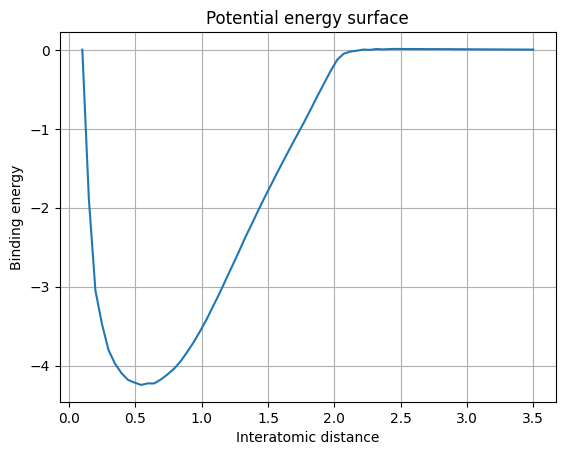

In [26]:
plot_binding_curve(
    distance_array=distances,
    binding_energy_array=binding_energies[1]
)

### Entanglement entropy

In [5]:
from math import log
from scipy import linalg



In [ ]:
entropy_array.shape

In [ ]:
entropy_array.astype('float32').tofile(os.path.join(mathematica_dir, 'entropies.dat'))

In [9]:
def plot_entropy(
    distance_array: np.ndarray,
    entropy_array: np.ndarray
) -> None:
    
    fig, axes = plt.subplots(nrows=1, ncols=1)
    #axes.scatter(distance_array[4:], binding_energy_array[4:], s=10)
    axes.plot(distance_array, entropy_array)
    axes.set_xlabel('Interatomic distance')
    axes.set_ylabel('Binding energy')
    axes.grid(True)
    axes.set_title('Entanglement entropy')
    plt.show()
    #plt.savefig(save_path, dpi=300, transparent=False, bbox_inches='tight')

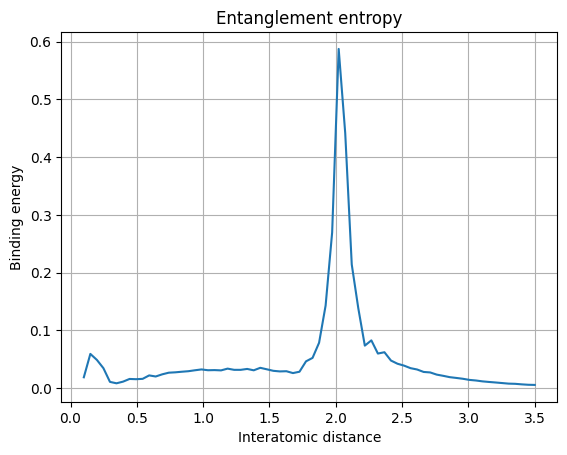

In [28]:
plot_entropy(
    distance_array=distances,
    entropy_array=entropy_array[1]
)

In [11]:
def plot_binding_entropy(
    distance_array: np.ndarray,
    binding_energy_array: np.ndarray,
    entropy_array: np.ndarray
) -> None:
    
    fig, axes = plt.subplots(nrows=1, ncols=1)
    #axes.scatter(distance_array[4:], binding_energy_array[4:], s=10)
    axes.plot(distance_array, entropy_array)
    axes.plot(distance_array, binding_energy_array)
    axes.set_xlabel('Interatomic distance')
    axes.set_ylabel('Binding energy')
    axes.grid(True)
    axes.set_title('Entanglement entropy')
    plt.show()
    #plt.savefig(save_path, dpi=300, transparent=False, bbox_inches='tight')

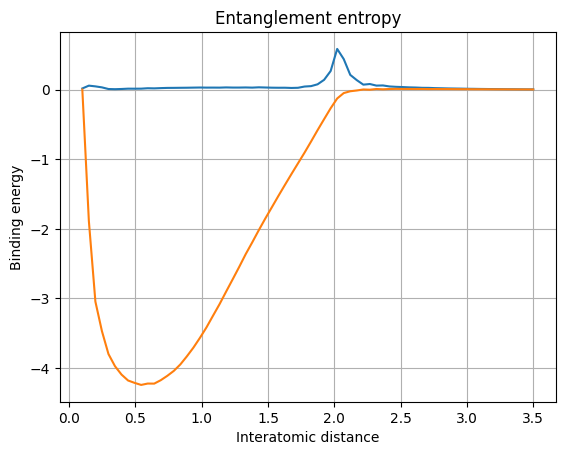

In [29]:
angle = 1
plot_binding_entropy(
    distance_array=distances,
    binding_energy_array=binding_energies[angle],
    entropy_array=entropy_array[angle]
)

### Wigner functions vizualization

In [ ]:
distances[3]

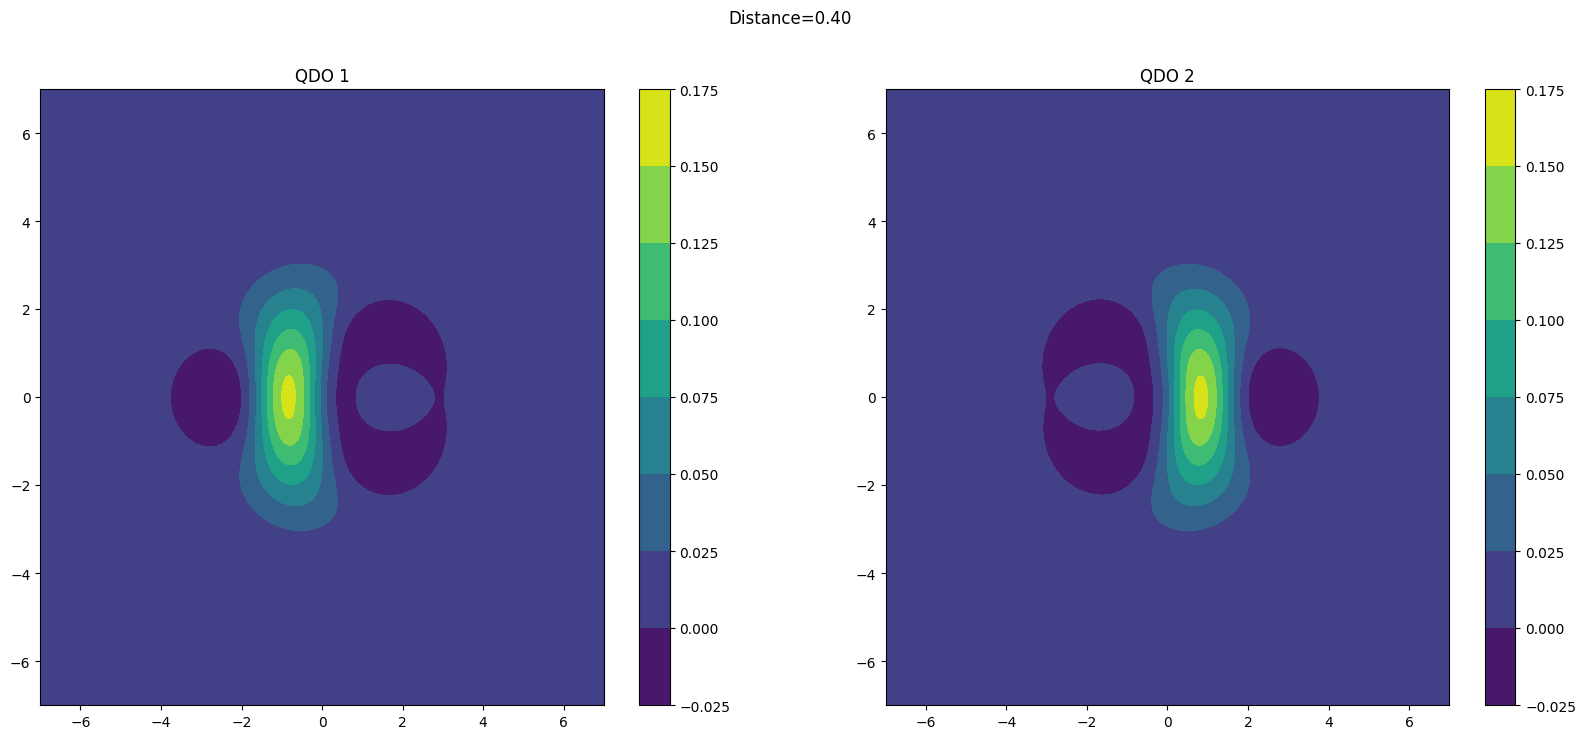

In [30]:
fig_dir = os.path.join(dir, 'figures')
os.makedirs(fig_dir, exist_ok=True)

X, P = np.meshgrid(quadrature_grid, quadrature_grid)

angle = 1
distance = 6

state = FockStateTF(state_data=states[angle, distance], num_modes=2, pure=True, cutoff_dim=args['cutoff_dim'])

w_qdo1 = state.wigner(mode=0, xvec=quadrature_grid, pvec=quadrature_grid)
w_qdo2 = state.wigner(mode=1, xvec=quadrature_grid, pvec=quadrature_grid)
fig = plt.figure(figsize=(20, 8))
ax1 = fig.add_subplot(1, 2, 1)#, projection='3d')
#ax1.plot_surface(X, P, w_qdo1, cmap=cm.coolwarm, lw=0.5, rstride=1, cstride=1)
heatmap1 = ax1.contourf(X, P, w_qdo1)#, cmap=cm.coolwarm, lw=0.5, rstride=1, cstride=1)
#ax1.set_axis_off()
ax1.set_title("QDO 1")
plt.colorbar(heatmap1)

ax2 = fig.add_subplot(1, 2, 2)#, projection='3d')
#ax2.plot_surface(X, P, w_qdo2, cmap=cm.coolwarm, lw=0.5, rstride=1, cstride=1)
heatmap2 = ax2.contourf(X, P, w_qdo2)#, cmap=cm.coolwarm, lw=0.5, rstride=1, cstride=1)
#ax2.set_axis_off()
ax2.set_title("QDO 2")
plt.colorbar(heatmap2)

plt.suptitle("Distance={:.2f}".format(distances[distance]))
#plt.savefig(os.path.join(fig_dir, "{:.4f}".format(distances[distance]) + '.png'))
plt.show()


In [ ]:
thetas[7]

In [ ]:
X, P = np.meshgrid(quadrature_grid, quadrature_grid)

angle = 7

fig_dir = os.path.join(dir, 'figures', 'wigner', 'angle={:.4f}'.format(thetas[angle]))
os.makedirs(fig_dir, exist_ok=True)

for distance in range(distances.shape[0]):
   
    state = FockStateTF(state_data=states[angle, distance], num_modes=args.modes, pure=True, cutoff_dim=args['cutoff_dim'])

    w_qdo1 = state.wigner(mode=0, xvec=quadrature_grid, pvec=quadrature_grid)
    w_qdo2 = state.wigner(mode=1, xvec=quadrature_grid, pvec=quadrature_grid)
    fig = plt.figure(figsize=(20, 8))
    ax1 = fig.add_subplot(1, 2, 1)#, projection='3d')
    #ax1.plot_surface(X, P, w_qdo1, cmap=cm.coolwarm, lw=0.5, rstride=1, cstride=1)
    heatmap1 = ax1.contourf(X, P, w_qdo1)#, cmap=cm.coolwarm, lw=0.5, rstride=1, cstride=1)
    #ax1.set_axis_off()
    ax1.set_title("QDO 1")
    plt.colorbar(heatmap1)

    ax2 = fig.add_subplot(1, 2, 2)#, projection='3d')
    #ax2.plot_surface(X, P, w_qdo2, cmap=cm.coolwarm, lw=0.5, rstride=1, cstride=1)
    heatmap2 = ax2.contourf(X, P, w_qdo2)#, cmap=cm.coolwarm, lw=0.5, rstride=1, cstride=1)
    #ax2.set_axis_off()
    ax2.set_title("QDO 2")
    plt.colorbar(heatmap2)

    plt.suptitle("Distance={:.2f}".format(distances[distance]))
    plt.savefig(os.path.join(fig_dir, "angle={:.4f}_distance={:.4f}".format(thetas[angle], distances[distance]) + '.png'))
    #plt.show()
    plt.close()


## Joint density vizualization

In [19]:
angle = 1

X1, X2 = np.meshgrid(quadrature_grid, quadrature_grid)

fig_dir = os.path.join(dir, 'figures', 'joint_density', 'angle={:.4f}'.format(thetas[angle]))
os.makedirs(fig_dir, exist_ok=True)

for distance in range(distances.shape[0]):
   
    joint_density = quadratures_density(
        x=quadrature_grid,
        alpha=states[angle, distance],
        num_modes=2,
        cutoff=args['cutoff_dim']
    )

    fig = plt.figure(figsize=(11, 8))
    ax1 = fig.add_subplot(1, 1, 1)#, projection='3d')
    #ax1.plot_surface(X1, X2, joint_density, cmap=cm.coolwarm, lw=0.5, rstride=1, cstride=1)
    heatmap1 = ax1.contourf(X1, X2, joint_density)
    plt.colorbar(heatmap1)
    ax1.set_axis_off()
    ax1.set_title("Position quadratures joint density, d={:.2f}".format(distances[distance]))
    plt.savefig(os.path.join(fig_dir, "angle={:.4f}_distance={:.4f}".format(thetas[angle], distances[distance]) + '.png'))
    plt.close()

## Marginal densities vizualization

In [ ]:
import glob

directory = 'logs/2023.02.16.10.49.17/theta=0.5890'
fig_dir = os.path.join(directory, 'figures')
os.makedirs(fig_dir, exist_ok=True)

states = glob.glob(os.path.join(directory, 'quad_marginals/distance=*'))
states.sort()
states = states[start:]

for file in states:
    
    distance = file.split('=')[2].split('.npy')[0]
    data = np.load(file)
    state = FockStateTF(state_data=data, num_modes=args.modes, pure=True, cutoff_dim=args.cutoff_dim)

    rho1 = data[0]
    rho2 = data[1]

    fig = plt.figure(figsize=(11, 8))
    ax = fig.add_subplot(1, 1, 1)
    ax.plot(x_quadrature_grid, rho1)
    ax.plot(x_quadrature_grid, rho2)
    ax.set_xlabel('Position relative to QDO center')
    ax.set_title("Marginal position quadrature densities")
    plt.yticks([])
    plt.savefig(os.path.join(fig_dir, distance + '.png'))
    plt.close()